# Devoir Python

Vous devez rendre votre devoir sur GitHub.
Vous avez le droit a tout vos documents et a internet

1. votre depot doit etre privé
2. vous devez inviter comme colaborateur votre chargé de TD/TP
3. Seul le dernier commit avant la fin de la séance sera corrigé.


Ex 1: Integrale de Romberg

Ecrire une fonction integ_romberg(f, a, b, epsilon=1e-6) permettant de calculer l’intégrale numérique de la fonction f entre les bornes a et b avec une précision epsilon selon la méthode de Romberg (https://fr.wikipedia.org/wiki/M%C3%A9thode_de_Romberg).

Il s’agit d’une méthode qui permet d’améliorer les méthodes usuelles de calcul numérique des intégrales, comme la méthode des Trapèzes.
On montre qu’en combinant judicieusement les valeurs obtenues par la méthode des Trapèzes pour différentes subdivisons de l’intervalle d’intégration, on augmente l’ordre de convergence (sa vitesse de convergence). 


In [116]:
#!/usr/bin/env python3


import numpy as np
import matplotlib.pyplot as plt


def f1(x):
   f1 = x**4.0
   return f1;

def f2(x):
   f2 = np.exp(-x*x)
   return f2;

def f3(x):
   tau   = 1.0e-8
   f3    = np.where(np.abs(x)<tau,1.0,np.sin(x)/x)
   return f3;

def trapezoid(f,a,b,N):
    h   = (b-a)/N
    xi  = np.linspace(a,b,N+1)
    fi  = f(xi)
    s   = 0.0
    for i in range(1,N):
        s = s + fi[i]
    s = (h/2)*(fi[0] + fi[N]) + h*s
    return s


def romberg(f,a,b,eps,nmax):
    Q         = np.zeros((nmax,nmax),float)
    converged = 0
    for i in range(0,nmax):
        N      = 2**i
        Q[i,0] = trapezoid(f,a,b,N)
        for k in range(0,i):
            n        = k + 2
            Q[i,k+1] = 1.0/(4**(n-1)-1)*(4**(n-1)*Q[i,k] - Q[i-1,k])
        if (i > 0):
            if (abs(Q[i,k+1] - Q[i,k]) < eps):
               converged = 1
               break
    print (Q[i,k+1],N,converged)    
    return Q[i,k+1],N,converged


a  = 0.0;b = 1.0 
romberg(f1,a,b,1.0e-12,10)

0.19999999999999996 8 1


(0.19999999999999996, 8, 1)

Ex 2: Équation d’état de l’eau à partir de la dynamique moléculaire

Afin de modéliser les planètes de type Jupiter, Saturne, ou même des exo-planètes très massives (dites « super-Jupiters »), la connaissance de l’équation d’état des composants est nécessaire. Ces équations d’état doivent être valables jusqu’à plusieurs centaines de méga-bar ; autrement dit, celles-ci ne sont en aucun cas accessibles expérimentalement. On peut cependant obtenir une équation d’état numériquement à partir d’une dynamique moléculaire.

Le principe est le suivant : on place dans une boite un certain nombre de particules régies par les équations microscopiques (Newton par exemple, ou même par des équations prenant en considération la mécanique quantique) puis on laisse celles-ci évoluer dans la boite ; on calcule à chaque pas de temps l’énergie interne à partir des intéractions électrostatiques et la pression à partir du tenseur des contraintes. On obtient en sortie l’évolution du système pour une densité fixée (par le choix de taille de la boite) et une température fixée (par un algorithme de thermostat que nous ne détaillerons pas ici).

On se propose d’analyser quelques fichiers de sortie de tels calculs pour l’équation d’état de l’eau à très haute pression. Les fichiers de sortie sont disponibles ici; leur nom indique les conditions thermodynamiques correspondant au fichier, p.ex. 6000K_30gcc.out pour T=6000
K et ρ=30 gcc. Le but est, pour chaque condition température-densité, d’extraire l’évolution de l’énergie et de la pression au cours du temps, puis d’en extraire la valeur moyenne ainsi que les fluctuations. Il arrive souvent que l’état initial choisi pour le système ne corresponde pas à son état d’équilibre, et qu’il faille donc « jeter » les quelques pas de temps en début de simulation qui correspondent à cette relaxation du système. Pour savoir combien de temps prend cette relaxation, il sera utile de tracer l’évolution au cours du temps de la pression et l’énergie pour quelques simulations. Une fois l’équation d’état P(ρ,T) et E(ρ,T) extraite, on pourra tracer le réseau d’isothermes.

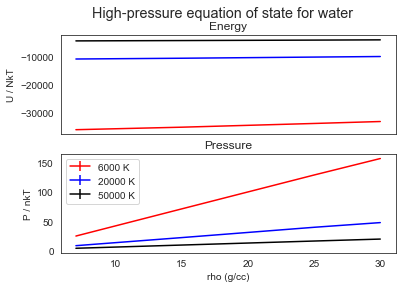

In [117]:
#!/usr/bin/env python3


import numpy as N
import matplotlib.pyplot as P
import pytest                    



tolerance = 1e-8  



class Simulation:
    

    def __init__(self, temp, dens, path):
       
        self.temp = float(temp)
        self.dens = float(dens)
        tmp = N.loadtxt(path, skiprows=1).T
        self.pot = tmp[0]
        self.kin = tmp[1]
        self.tot = self.pot + self.kin
        self.press = tmp[2]

    def __str__(self):
       
        return "Simulation at {:.0f} g/cc and {:.0f} K ; {:d} timesteps". \
            format(self.dens, self.temp, len(self.pot))

    def thermo(self, skipSteps=0):
        
        return {'T': self.temp,
                'rho': self.dens,
                'E': self.tot[skipSteps:].mean(),
                'P': self.press[skipSteps:].mean(),
                'dE': self.tot[skipSteps:].std(),
                'dP': self.press[skipSteps:].std()}

    def plot(self, skipSteps=0):
        
        fig, (axen, axpress) = P.subplots(2, sharex=True)
        axen.plot(list(range(skipSteps, len(self.tot))), self.tot[skipSteps:],
                  'rd--')
        axen.set_title("Internal energy (Ha)")
        axpress.plot(list(range(skipSteps, len(self.press))), self.press[skipSteps:],
                     'rd--')
        axpress.set_title("Pressure (GPa)")
        axpress.set_xlabel("Timesteps")

        P.show()


def mimic_simulation(filename):
    with open(filename, 'w') as f:
        f.write("""Potential energy (Ha)	Kinetic Energy (Ha)	Pressure (GPa)
-668.2463567264        	0.7755612311   		9287.7370229824
-668.2118514558        	0.7755612311		9286.1395903265
-668.3119088218        	0.7755612311		9247.6604398856
-668.4762735176        	0.7755612311		9191.8574820856
-668.4762735176        	0.7755612311		9191.8574820856
""")


def test_Simulation_init():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 10, "equationEtat_simuTest.out")
    assert len(s.kin) == 5
    assert abs(s.kin[2] - 0.7755612311) < tolerance
    assert abs(s.pot[1] + 668.2118514558) < tolerance


def test_Simulation_str():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 20, "equationEtat_simuTest.out")
    assert str(s) == "Simulation at 20 g/cc and 10 K ; 5 timesteps"


def test_Simulation_thermo():
    mimic_simulation("equationEtat_simuTest.out")
    s = Simulation(10, 20, "equationEtat_simuTest.out")
    assert abs(s.thermo()['T'] - 10) < tolerance
    assert abs(s.thermo()['rho'] - 20) < tolerance
    assert abs(s.thermo()['E'] + 667.56897157674) < tolerance
    assert abs(s.thermo()['P'] - 9241.0504034731) < tolerance
    assert abs(s.thermo(3)['E'] + 667.7007122865) < tolerance
    assert abs(s.thermo(3)['P'] - 9191.8574820856) < tolerance



if __name__ == '__main__':


    
    a0 = 0.52918   
    amu = 1.6605     
    k_B = 3.16681e-6  
    nk_GPa = a0 ** 3 * k_B * 2.942e4 / 6 / amu
    nsteps = 200  
  
    temps = [6000, 20000, 50000]  
    colors = {6000: 'r', 20000: 'b', 50000: 'k'}
    denss = [7, 15, 25, 30]  
    keys = ['T', 'rho', 'E', 'dE', 'P', 'dP']
    eos = dict.fromkeys(keys, N.zeros(0))   


    for t, rho in [(t, rho) for t in temps for rho in denss]:
        filenm = "outputs/{}K_{:0>2d}gcc.out".format(t, rho)
        s = Simulation(t, rho, filenm)
        for key in keys:
            eos[key] = N.append(eos[key], s.thermo(nsteps)[key])

    fig, (axen, axpress) = P.subplots(2, sharex=True)
    fig.suptitle("High-pressure equation of state for water", size='x-large')
    axen.set_title("Energy")
    axen.set_ylabel("U / NkT")
    axpress.set_title("Pressure")
    axpress.set_ylabel("P / nkT")
    axpress.set_xlabel("rho (g/cc)")
    for t in temps:
        sel = eos['T'] == t
        axen.errorbar(x=eos['rho'][sel], y=eos['E'][sel] / k_B / t,
                      yerr=eos['dE'][sel] / k_B / t, fmt=colors[t] + '-')
        axpress.errorbar(x=eos['rho'][sel],
                         y=eos['P'][sel] / eos['rho'][sel] / nk_GPa / t,
                         yerr=eos['dP'][sel] / eos['rho'][sel] / nk_GPa / t,
                         fmt=colors[t] + '-',
                         label="{} K".format(t))
    axpress.legend(loc='best')
    P.show()

Ex 3: Le problème du voyageur de commerce

Le problème du voyageur de commerce est un problème d’optimisation consistant à déterminer le plus court chemin reliant un ensemble de destinations. Il n’existe pas d’algorithme donnant la solution optimale en un temps raisonnable (problème NP-complet), mais l’on peut chercher à déterminer des solutions approchées. On va se placer ici dans le cas d’un livreur devant desservir une seule fois chacune desndestinations d’une ville américaine où les rues sont agencées en réseau carré. 

On utilise la « distance deManhattan »  entre deux points 𝐴(𝑥𝐴,𝑦𝐴) et 𝐵(𝑥𝐵,𝑦𝐵) : 𝑑(𝐴,𝐵) =|𝑥𝐵−𝑥𝐴|+|𝑦𝐵−𝑦𝐴|.

En outre, on se place dans le cas où les coordonnées des destinations sont entières, comprises entre 0 (inclus) et TAILLE = 50 (exclus). Deux destinations peuvent éventuellement avoir les mêmes coordonnées. Les instructions suivantes doivent permettre de définir les classes nécessaires (Ville et Trajet) et de développer un algorithme approché (heuristiques) : l’algorithme du plus proche voisin. 

Seules la librairie standard et la librairie numpy sont utilisables si nécessaire. Implementer les classes et methodes suivante:


Classe Ville:
* __init__(): initialisation d’une ville sans destination.
* aleatoire(n): création de n destinations aléatoires.
* nb_trajet(): retourne le nombre total (entier) de trajets :(𝑛−1)!/2(utilisermath.factorial()).
* distance(i, j): retourne la distance (Manhattan) entre les deux destinations de numéro i et j


Classe Trajet:
* __init__(ville, etapes=None): initialisation sur une ville. Si la liste etapes n’est pas spécifiée, le trajet par défaut est celui suivant les destinations de ville.
* longueur(): retourne la longueur totale du trajetbouclé(i.e. revenant à son point de départ).


Plus proche voisin:
* Ville.plus_proche(i, exclus=[]): retourne la destination la plus proche de la destinationi(au sens de Ville.distance()), hors les destinations de la liste exclus
* Ville.trajet_voisins(depart=0): retourne un Trajet déterminé selon l’heuristique des plus proches voisins (i.e. l’étape suivante est la destination la plus proche hors les destinations déjà visitées) en partant de l’étape initiale depart

Optimisation:
* Proposer un algorithme qui propose une meilleur alternative au "plus proche voisin".

Interface:
* Ville.figure(trajet=None): Afficher le plande la ville et le trajet obtenue (utiliser matplotlib.step()pour des trajets de type « Manhattan »)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:175: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:175: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:175: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.


20-trajet L=774: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Trajet PPV: 20-trajet L=288: [ 0  6  2 11  9  4  1 19 18  7  8  5 16  3 14 10 17 12 15 13]
Optimisation: L=288 -> 284
Optimisation: L=284 -> 278
Optimisation: L=278 -> 276
opt2: optimisation en 4 iterations
Trajet PPV + opt-2: 20-trajet L=276: [ 0  6  2 11  9  4  1 18 19 16  5  8  7  3 14 10 17 12 15 13]


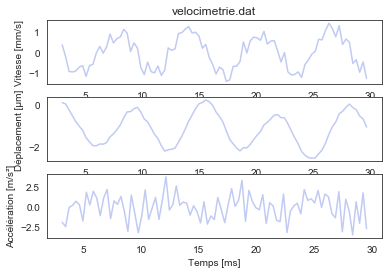

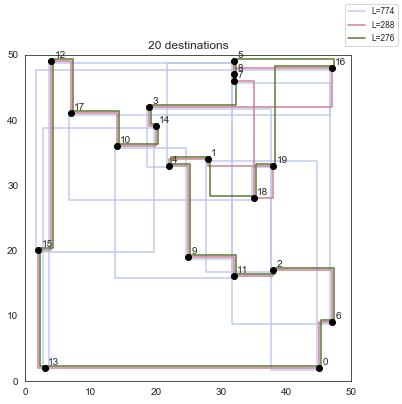

In [120]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


from __future__ import division

import math
import numpy as N
import pytest

import matplotlib.pyplot as P

N.random.seed(123)
TAILLE = 50

class Ville(object):

    

    def __init__(self):
        
        self.destinations = N.array([]).reshape(-1, 2)

    def __str__(self):

        return "Ville: {} destinations ({} trajets)".format(
            len(self.destinations), self.nb_trajets())

    def aleatoire(self, n=20):


        self.destinations = N.random.randint(TAILLE, size=(n, 2))

    def lecture(self, nomfichier="ville.dat"):


        try:
            self.destinations = N.loadtxt(nomfichier, dtype=int)
            if self.destinations.ndim != 2 or self.destinations.shape[1] != 2:
                raise IOError
        except IOError:
            raise IOError("Le fichier {!r} est invalide".format(nomfichier))

    def ecriture(self, nomfichier="ville.dat"):


        N.savetxt(nomfichier, self.destinations, fmt='%d')

    def nb_trajets(self):
        

        ndest = len(self.destinations)
        if ndest > 2:
            return int(math.factorial(ndest - 1) / 2)
        elif ndest > 0:
            return 1
        else:
            return 0

    def distance(self, i, j):


        return N.abs(self.destinations[i] - self.destinations[j]).sum()

    def plus_proche(self, i, exclus=[]):


        voisins = [ j for j in range(len(self.destinations))
                    if j != i and j not in exclus ]
        distances = [ self.distance(i, j) for j in voisins ]

        return voisins[N.argmin(distances)]

    def trajet_voisins(self, depart=0):


        ndest = len(self.destinations)
        if depart is None:     # Boucle sur tous les départs possibles
            trajets = [ self.trajet_voisins(depart=i) for i in range(ndest) ]
            longueurs = [ t.longueur() for t in trajets ]

            return trajets[N.argmin(longueurs)]
        else:                  # Départ imposé
            etapes = [depart]
            while len(etapes) < ndest:
                i = etapes[-1]
                j = self.plus_proche(i, exclus=etapes[:-1])
                etapes.append(j)

            return Trajet(self, etapes)

    def optimisation_trajet(self, trajet):


        ndest = len(self.destinations)
        trajets = [ trajet.interversion(i, j)
                    for i in range(ndest) for j in range(i+1, ndest) ]
        longueurs = [ t.longueur() for t in trajets ]
        opt = trajets[N.argmin(longueurs)]
        if opt.longueur() > trajet.longueur():
            opt = trajet

        return opt

    def trajet_opt2(self, trajet=None, maxiter=100):


        if trajet is None:
            trajet = self.trajet_voisins()

        for i in range(maxiter):
            opt = self.optimisation_trajet(trajet)
            if opt.longueur() == trajet.longueur():
                break
            else:
                print ("Optimisation: L={} -> {}".format(
                    trajet.longueur(), opt.longueur()))
                trajet = opt
        print ("opt2: optimisation en {} iterations".format(i+1))

        return opt

    def figure(self, trajet=None, ax=None, offset=0):


        if ax is None:
            fig = P.figure(figsize=(6,6))
            ax = fig.add_subplot(1,1,1, aspect='equal',
                                 xlim=(0, TAILLE), ylim=(0, TAILLE),
                                 title="{} destinations".format(
                                     len(self.destinations)))
            minor_loc = P.matplotlib.ticker.MultipleLocator(1)
            ax.xaxis.set_minor_locator(minor_loc)
            ax.yaxis.set_minor_locator(minor_loc)
            ax.autoscale(False)

        if trajet is None:
            ax.plot(self.destinations[:, 0], self.destinations[:, 1],
                    'ko', zorder=10)
            for i,(x,y) in enumerate(self.destinations):
                #ax.text(x, y, ' '+str(i))
                ax.annotate(str(i), xy=(x, y), xytext=(x+0.5, y+0.5), zorder=10)
        else:
            boucle = N.concatenate((trajet.etapes, [trajet.etapes[0]]))
            ax.step(self.destinations[boucle, 0] + offset,
                    self.destinations[boucle, 1] + offset,
                    label="L={}".format(trajet.longueur()))

        return ax


class Trajet(object):



    def __init__(self, ville, etapes=None):


        assert isinstance(ville, Ville)
        self.ville = ville
        if etapes is None:                     # Trajet par défaut
            self.etapes = N.arange(len(self.ville.destinations))
        else:
            self.etapes = N.array(etapes)

    def __str__(self):

        return "{}-trajet L={}: {}".format(
            len(self.etapes), self.longueur(), self.etapes)

    def longueur(self):


        l = sum( self.ville.distance(self.etapes[i], self.etapes[i+1])
                 for i in range(len(self.etapes)-1) )
        l += self.ville.distance(self.etapes[-1], self.etapes[0])

        return l

    def interversion(self, i, j):


        etapes = self.etapes.copy()
        etapes[[i, j]] = etapes[[j, i]]

        return Trajet(self.ville, etapes)


def fig_velocimetrie(nomfichier="velocimetrie.dat"):


    # Lecture du fichier d'entrée, en sautant la 1ère ligne
    t, vel = N.loadtxt(nomfichier, skiprows=1, unpack=True)

    dt = t[1] - t[0]            # Pas de temps [ms]
    assert N.allclose(N.diff(t), dt), "Échantillonage en temps non-uniforme"

    fig = P.figure()

    # 1er axe: v(t)
    ax1 = fig.add_subplot(3, 1, 1,
                          ylabel="Vitesse [mm/s]",
                          title=nomfichier)
    ax1.plot(t, vel)

    # 2nd axe: x(t)
    ax2 = fig.add_subplot(3, 1, 2,
                          ylabel=u"Déplacement [µm]")
    ax2.plot(t, N.cumsum(vel) * dt)

    # 3ème axe: a(t)
    ax3 = fig.add_subplot(3, 1, 3,
                          xlabel="Temps [ms]",
                          ylabel=u"Accélération [m/s²]")
    tmid = 0.5 * (t[1:] + t[:-1])
    ax3.plot(tmid, N.diff(vel) / dt)

    return fig


def test_ville_aleatoire():

    ville = Ville()
    ville.aleatoire(10)
    assert ville.destinations.shape == (10, 2)
    assert N.issubdtype(ville.destinations.dtype, int)

def test_ville_lecture():

    ville = Ville()
    ville.lecture("ville.dat")
    assert ville.destinations.shape == (20, 2)
    assert (ville.destinations[:3] == [[45, 2], [28, 34], [38, 17]]).all()

@pytest.fixture
def ville_test():

    ville = Ville()
    ville.destinations = N.array([[0, 0], [1, 1], [3, 0], [2, 2]])
    return ville

def test_ville_ecriture(ville_test):

    ville_test.ecriture("test_ecriture.dat")
    ville = Ville()
    ville.lecture("test_ecriture.dat")
    assert (ville_test.destinations == ville.destinations).all()

def test_ville_trajets(ville_test):

    assert ville_test.nb_trajets() == 3

def test_ville_distance(ville_test):

    assert ville_test.distance(0, 1) == 2
    assert ville_test.distance(1, 2) == 3
    assert ville_test.distance(2, 0) == 3

def test_trajet_init(ville_test):

    trajet = Trajet(ville_test)
    assert (trajet.etapes == range(4)).all()

@pytest.fixture
def trajet_test(ville_test):

    return Trajet(ville_test)

def test_trajet_longueur(trajet_test):

    assert trajet_test.longueur() == 12

def test_ville_plus_proche(ville_test):

    assert ville_test.plus_proche(0) == 1
    assert ville_test.plus_proche(0, [1, 2]) == 3

def test_ville_trajet_voisins(ville_test):

    assert (ville_test.trajet_voisins(depart=0).etapes == [0, 1, 3, 2]).all()

def test_trajet_interversion(trajet_test):

    assert (trajet_test.interversion(0, 1).etapes == [1, 0, 2, 3]).all()

def test_ville_optimisation_trajet(ville_test, trajet_test):

    assert (ville_test.optimisation_trajet(trajet_test).etapes ==
            [1, 0, 2, 3]).all()



if __name__ == '__main__':

    import os


    fig = fig_velocimetrie("velocimetrie.dat")
    fig.savefig("velocimetrie.png")


    try:
        import seaborn
        seaborn.set_style("white")
        seaborn.set_palette("cubehelix_r", 4)
    except ImportError:
        pass

    ville = Ville()
    if not os.path.exists("ville.dat"):
        ville.aleatoire(n=20)
        print(ville)
        ville.ecriture("ville.dat")
    else:
        ville.lecture("ville.dat")


    ax = ville.figure()


    trajet = Trajet(ville)
    print(trajet)
    ville.figure(trajet, ax=ax, offset=-0.3)


    trajet_voisins = ville.trajet_voisins(depart=0)
    print ("Trajet PPV:", trajet_voisins)
    ville.figure(trajet_voisins, ax=ax)


    trajet_opt2 = ville.trajet_opt2(trajet_voisins)
    print ("Trajet PPV + opt-2:", trajet_opt2)
    ville.figure(trajet_opt2, ax=ax, offset=0.3)

    h, l = ax.get_legend_handles_labels()
    ax.figure.legend(h, l, fontsize='small', loc='upper right')

    P.show()
